In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
should_skip = True

In [3]:
#@title Install libraries
if not should_skip:
  !pip install -U -qq git+https://github.com/huggingface/diffusers.git
  !pip install -qq pytorch_lightning albumentations wandb gpustat gdown accelerate transformers ftfy

In [4]:
#@title Import required libraries
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TVF
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
import sys

# https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/unet_2d_condition.py#L175-L182
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

import matplotlib.pyplot as plt

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [5]:
if not should_skip:
    #@markdown Add here the URLs to the images of the concept you are adding. 3-5 should be fine
    train_urls = [
        "https://huggingface.co/datasets/valhalla/images/resolve/main/2.jpeg",
        "https://huggingface.co/datasets/valhalla/images/resolve/main/3.jpeg",
    ]
    test_urls = [
        "https://huggingface.co/datasets/valhalla/images/resolve/main/5.jpeg",
        "https://huggingface.co/datasets/valhalla/images/resolve/main/6.jpeg",
        ## You can add additional images here
    ]
#@title Download
import requests
import glob
from io import BytesIO

def download_image(url):
  try:
    response = requests.get(url)
  except:
    return None
  return Image.open(BytesIO(response.content)).convert("RGB")

if not should_skip:
    for save_path,urls in [("./my_concept",train_urls),("./my_concept_test",test_urls)]:
      images = list(filter(None,[download_image(url) for url in urls]))
      if not os.path.exists(save_path):
        os.mkdir(save_path)
      [image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(images)]


if not should_skip:
    !gdown --id 1I8RMKQhPXntlRKorVNZ6yyNpfaOp8wNv
    mask_path="./my_concept_gt"
    !mkdir $mask_path/

    with open("my_concept_gt.zip","r") as f:
        pass
    !unzip -o my_concept_gt.zip

In [6]:
# %cd /content/
# sys.path.append("/content/slime-experiments/")

In [7]:
# !rm -rf slime-experiments/
# !git clone https://github.com/andrew-healey/slime-experiments
# !cd slime-experiments && git rev-parse --short HEAD

In [8]:
from slime.slime import SLiME
from slime.data.single_class import BinarySegmentationDataset,SegmentationDataModule

In [9]:
train_dataset = BinarySegmentationDataset(
    data_root="my_concept",
    mask_root="my_concept_gt",
)
test_dataset = BinarySegmentationDataset(
    data_root="my_concept_test",
    mask_root=None,
    use_augmentations=False,
)

data_module = SegmentationDataModule(
    train_dataset,
    test_dataset,
    iters_per_epoch=50,
    batch_size=1,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


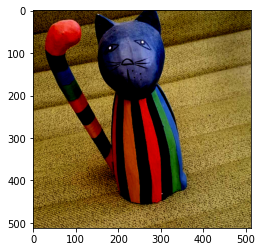

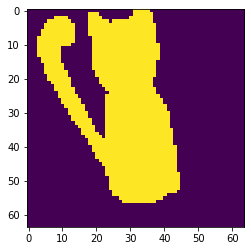

In [10]:
demo_row = train_dataset[0]

gt_mask = demo_row["gt_masks_oh"]
img = demo_row["pixel_values"]
plt.imshow(img.permute(1,2,0))
plt.show()
plt.imshow(gt_mask[...,0])

In [11]:
slime = SLiME(
    use_self_attn=False,
    alpha=1.0,
    gamma=1.0,
    lr=0.1,
    multiplier_lr=0.1,
    # cross_attn_nums=[8]
).cuda()

/usr/local/lib/python3.8/dist-packages/diffusers/configuration_utils.py:239: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


In [12]:
from pytorch_lightning import Trainer

trainer = Trainer(
    default_root_dir="run",
    limit_train_batches=1.0,
    num_sanity_val_steps=0,
    max_epochs=1,
    enable_checkpointing=False,
)

trainer.fit(slime, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type            | Params
-----------------------------------------------------------
0 | sd                     | StableDiffusion | 900 M 
1 | cross_layer_multiplier | Multiplier      | 32    
2 | self_layer_multiplier  | Multiplier      | 32    
3 | cross_map_multiplier   | Multiplier      | 4     
4 | pred_map_

Training: |          | 0/? [00:00<?, ?it/s]

pred -2.05 2.11 ce loss 1.04 mse loss 0.4 dice loss 0.67
pred -1.07 2.08 ce loss 0.41 mse loss 0.12 dice loss 0.38
pred -2.31 1.77 ce loss 0.47 mse loss 0.15 dice loss 0.37
pred -1.26 2.04 ce loss 0.56 mse loss 0.19 dice loss 0.4
pred -2.54 2.77 ce loss 0.56 mse loss 0.19 dice loss 0.4
pred -2.66 1.97 ce loss 0.59 mse loss 0.2 dice loss 0.48
pred -1.41 2.08 ce loss 0.5 mse loss 0.16 dice loss 0.37
pred -1.64 2.12 ce loss 0.35 mse loss 0.09 dice loss 0.32
pred -3.06 3.18 ce loss 0.66 mse loss 0.23 dice loss 0.44
pred -2.58 3.02 ce loss 0.45 mse loss 0.14 dice loss 0.3
pred -2.17 3.03 ce loss 0.34 mse loss 0.09 dice loss 0.25
pred -1.64 2.77 ce loss 0.55 mse loss 0.18 dice loss 0.39
pred -2.24 3.16 ce loss 0.84 mse loss 0.3 dice loss 0.41
pred -2.47 2.91 ce loss 0.33 mse loss 0.09 dice loss 0.29
pred -3.58 3.85 ce loss 0.4 mse loss 0.12 dice loss 0.23
pred -1.8 3.24 ce loss 0.28 mse loss 0.07 dice loss 0.24
pred -2.83 3.65 ce loss 0.56 mse loss 0.19 dice loss 0.33
pred -2.43 3.46 ce loss

`Trainer.fit` stopped: `max_epochs=1` reached.


pred -3.2 5.31 ce loss 0.16 mse loss 0.04 dice loss 0.14


In [13]:
slime.cuda(); 0

0

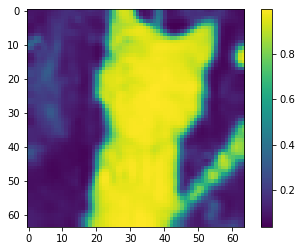

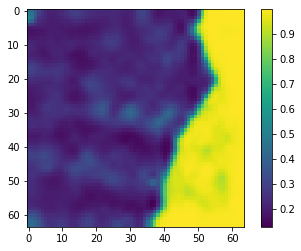

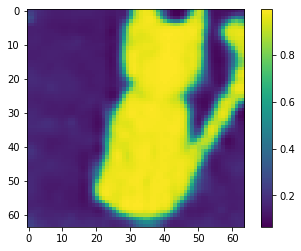

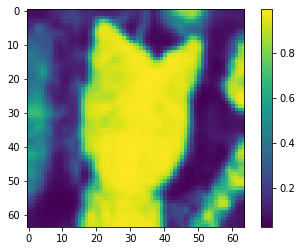

In [14]:
import matplotlib.pyplot as plt
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
for i in range(4):
    a = sigmoid(slime.latest_preds[-1-i].swapaxes(1,2).reshape((-1,slime.text_tokens,64,64))[0,1])
    plt.imshow(a)
    plt.colorbar()
    plt.show()

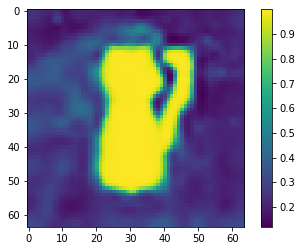

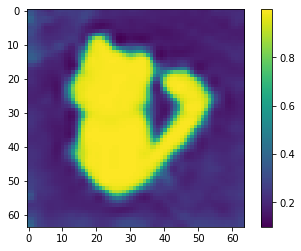

In [15]:
#@title Infer on test set
out_mask = None
loader = data_module.test_dataloader()
out_masks=[]
for i,batch in enumerate(loader):
  out_mask = slime.predict_step(batch,i).cpu().numpy()
  out_masks.append(out_mask)

import matplotlib.pyplot as plt
for out_mask in out_masks:
  for j in range(len(out_mask)):
    plt.imshow(sigmoid(out_mask[j,:,1].reshape((64,64))))
    plt.colorbar()
    plt.show()

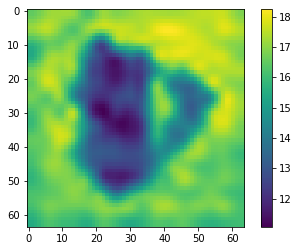

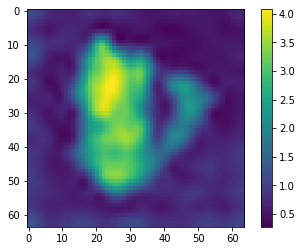

tensor([ 1.3840,  0.8901, -0.1042,  0.4428,  2.8572,  0.9512,  0.9512,  0.9512,
         0.9512,  0.9512,  0.9512,  0.9512,  0.9512,  0.9512,  0.9512,  0.9512],
       device='cuda:0')


In [16]:
preds = slime.latest_means
# print([(pred.shape,pred.mean(axis=1)) for pred in preds])

for pred in preds:
    for i in range(pred.shape[1]):
        plt.imshow(pred[0,i].reshape((64,64)))
        plt.colorbar()
        plt.show()

print(slime.cross_layer_multiplier.weight.data)

[(20, 256, 4), (20, 256, 4), (20, 256, 4), (10, 1024, 4), (10, 1024, 4)]
Layer 0


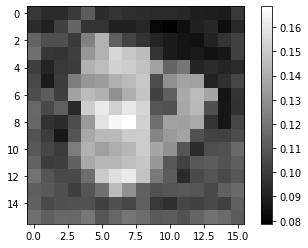

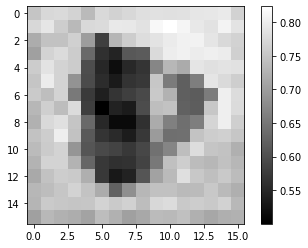

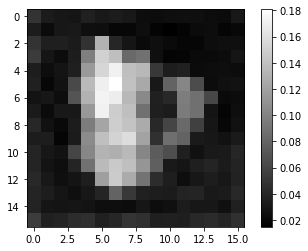

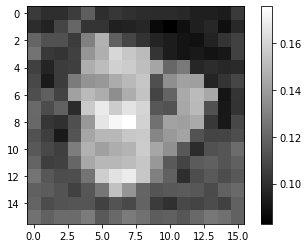

Layer 1


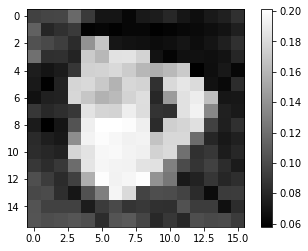

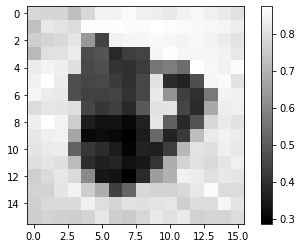

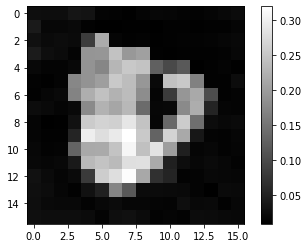

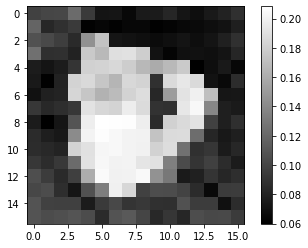

Layer 2


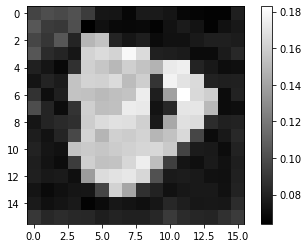

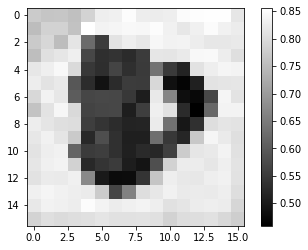

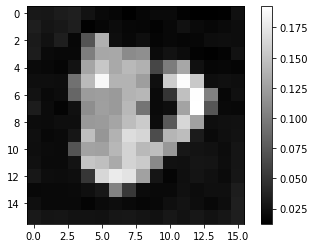

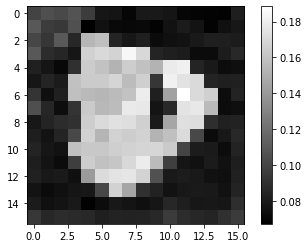

Layer 3


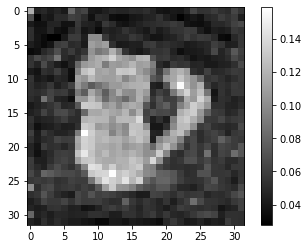

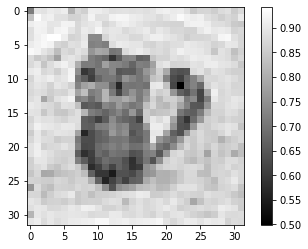

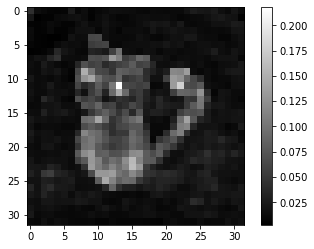

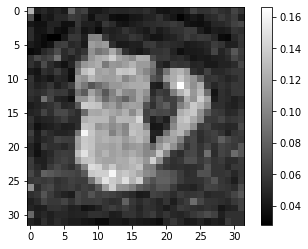

Layer 4


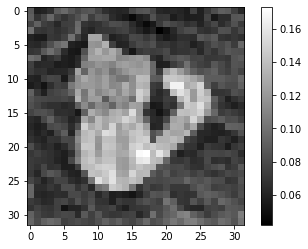

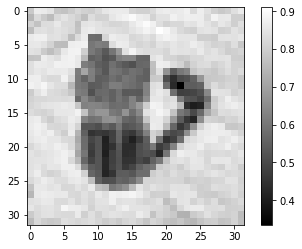

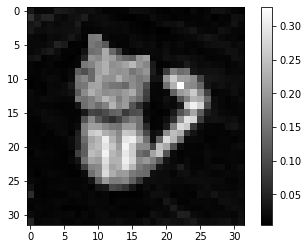

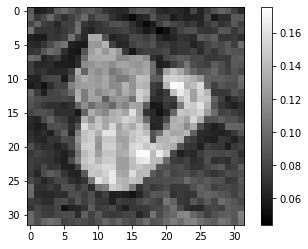

tensor([ 1.3840,  0.8901, -0.1042,  0.4428,  2.8572,  0.9512,  0.9512,  0.9512,
         0.9512,  0.9512,  0.9512,  0.9512,  0.9512,  0.9512,  0.9512,  0.9512],
       device='cuda:0')


In [17]:
xattns = slime.latest_xattns
print([(xattn.shape) for xattn in xattns])

for i,xattn in enumerate(xattns):
    print("Layer",i)
    img_tokens = xattn.shape[1]
    img_dim = int(math.sqrt(img_tokens))
    reshaped = xattn.mean(axis=0,keepdims=True).reshape((img_dim,img_dim,-1))
    for j in range(reshaped.shape[-1]):
        plt.imshow(reshaped[...,j],cmap="gray")
        plt.colorbar()
        plt.show()

print(slime.cross_layer_multiplier.weight.data)